In [2]:
## necessary modules

import os
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

## pytorch imports
import catboost as cbs
import shap

## preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

## metrics
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score, recall_score, log_loss

In [4]:
dataset = pd.read_csv("raw/train.csv", index_col=0)
dataset.sample(5)

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country
37389,21,Private,221418,HS-grad,9,Never-married,Other-service,Own-child,White,Female,0,0,40,United-States
24153,39,Private,53569,Assoc-voc,11,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States
21110,40,Private,184655,Assoc-acdm,12,Never-married,Other-service,Other-relative,White,Male,0,0,25,United-States
11059,68,Private,185537,Some-college,10,Divorced,Sales,Not-in-family,White,Female,0,0,20,United-States
41437,42,Private,268183,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,1485,60,United-States


In [5]:
targets = pd.read_csv("raw/train_class_labels.csv", index_col=0)
targets.head(5)

,income_>50K
0,1
1,0
2,1
3,0
4,0


In [6]:
#### 1. missing values ####

full_dataset = dataset.drop(dataset[dataset.workclass == '?'].index) # removes around 2000 rows

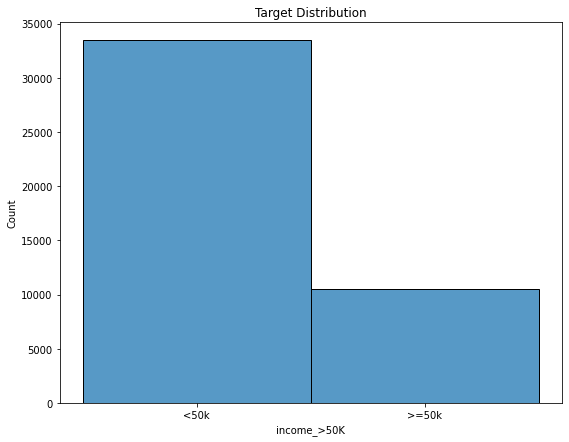


Minority sample ratio: 0.23927929567531905


In [7]:
plt.figure(figsize = (9, 7))
sns.histplot(x = targets["income_>50K"], discrete = True)
plt.title("Target Distribution")
plt.xticks([0,1], ["<50k", ">=50k"])
plt.show()
print()
minority_sample_ratio = (targets["income_>50K"] == 1).sum() / targets["income_>50K"].count()
print(f"Minority sample ratio: {minority_sample_ratio}")

In [8]:
#### 2. Drop educational-num
numerical_dataset = full_dataset.drop("educational-num", axis = 1)

In [9]:
#### 3. scale all numerical values ####

for i in ["age", "fnlwgt", "capital-gain", "capital-loss", "hours-per-week"]:
    numerical_dataset[i] = MinMaxScaler().fit_transform(np.expand_dims(numerical_dataset[i].values, axis = 1))

In [10]:
numerical_dataset

,age,workclass,fnlwgt,education,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country
0,0.684932,Private,0.238967,Doctorate,Divorced,Exec-managerial,Not-in-family,White,Male,1.0,0.0,0.602041,United-States
1,0.000000,Private,0.156482,12th,Never-married,Other-service,Own-child,White,Male,0.0,0.0,0.142857,United-States
2,0.191781,Private,0.108814,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,0.397959,United-States
3,0.561644,State-gov,0.065479,7th-8th,Married-civ-spouse,Transport-moving,Husband,White,Male,0.0,0.0,0.397959,United-States
4,0.109589,State-gov,0.091919,Some-college,Never-married,Other-service,Not-in-family,Black,Male,0.0,0.0,0.397959,United-States
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43952,0.479452,Private,0.037572,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,0.500000,United-States
43953,0.027397,Private,0.069788,HS-grad,Never-married,Other-service,Own-child,White,Female,0.0,0.0,0.397959,United-States
43954,0.178082,Private,0.124893,Some-college,Divorced,Sales,Not-in-family,White,Male,0.0,0.0,0.581633,United-States
43955,0.397260,Private,0.057140,Bachelors,Never-married,Sales,Not-in-family,White,Female,0.0,0.0,0.346939,United-States


In [13]:
cat_list = ["workclass", "education", "marital-status", "occupation", "relationship", "race", "gender", "native-country"]

new_df = pd.get_dummies(numerical_dataset, columns = cat_list, drop_first = True)

In [14]:
# drop all null values
X = new_df.copy().dropna().reset_index().drop('index', axis = 1)
y = targets.iloc[new_df.dropna().index].reset_index().drop('index', axis = 1)

In [18]:
X.dtypes.values

array([dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('uint8'), dtype('uint8'),
       dtype('uint8'), dtype('uint8'), dtype('uint8'), dtype('uint8'),
       dtype('uint8'), dtype('uint8'), dtype('uint8'), dtype('uint8'),
       dtype('uint8'), dtype('uint8'), dtype('uint8'), dtype('uint8'),
       dtype('uint8'), dtype('uint8'), dtype('uint8'), dtype('uint8'),
       dtype('uint8'), dtype('uint8'), dtype('uint8'), dtype('uint8'),
       dtype('uint8'), dtype('uint8'), dtype('uint8'), dtype('uint8'),
       dtype('uint8'), dtype('uint8'), dtype('uint8'), dtype('uint8'),
       dtype('uint8'), dtype('uint8'), dtype('uint8'), dtype('uint8'),
       dtype('uint8'), dtype('uint8'), dtype('uint8'), dtype('uint8'),
       dtype('uint8'), dtype('uint8'), dtype('uint8'), dtype('uint8'),
       dtype('uint8'), dtype('uint8'), dtype('uint8'), dtype('uint8'),
       dtype('uint8'), dtype('uint8'), dtype('uint8'), dtype('uint8'),
       dtype

## Catboost Learning

In [19]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

In [20]:
from imblearn.combine import SMOTETomek

oversample = SMOTETomek()
smo_X, smo_y = oversample.fit_resample(X, y)

In [25]:
from sklearn.model_selection import StratifiedKFold

# best model ever!!
skf = StratifiedKFold(shuffle = True)

for train_index, test_index in skf.split(smo_X, smo_y):
  X_train, X_test = smo_X.iloc[train_index], smo_X.iloc[test_index]
  y_train, y_test = smo_y.iloc[train_index], smo_y.iloc[test_index]
  cbc = cbs.CatBoostClassifier(loss_function="Logloss", verbose=False, task_type="GPU", devices='0-3')
  # cbc.fit(X = X_train, y = y_train, cat_features=cat_list)
  cbc.fit(X = X_train, y = y_train)
  train_preds = cbc.predict(X_train)
  test_preds = cbc.predict(X_test)

  print("AUC-ROC:")
  print("TRAIN: ", roc_auc_score(train_preds, y_train), "\t\tTEST:", roc_auc_score(test_preds, y_test))
  print("ACCURACY:")
  print("TRAIN: ", accuracy_score(train_preds, y_train), "\t\tTEST:", accuracy_score(test_preds, y_test))

AUC-ROC:
TRAIN:  0.9115209989328775 		TEST: 0.9011636383865943
ACCURACY:
TRAIN:  0.9114376798071689 		TEST: 0.9010262789612813
AUC-ROC:
TRAIN:  0.9112706382549641 		TEST: 0.900058027316157
ACCURACY:
TRAIN:  0.9111672660122461 		TEST: 0.8997745120908172
AUC-ROC:
TRAIN:  0.9100611769720228 		TEST: 0.9068790636436368
ACCURACY:
TRAIN:  0.9099232189717174 		TEST: 0.9068501671720706
AUC-ROC:
TRAIN:  0.9095082325687638 		TEST: 0.9071158944562436
ACCURACY:
TRAIN:  0.9094178248615026 		TEST: 0.9070056760749553
AUC-ROC:
TRAIN:  0.9100734932091958 		TEST: 0.9022353647544573
ACCURACY:
TRAIN:  0.9099815336767422 		TEST: 0.9021071456340876


In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Pool(X, y, cat_features=cat_features))